In [92]:
#Part 1 - Normalize peak area data using POC, construct pie charts showing treatment composition of individual metabolites, perform center scaling

# Import libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster import hierarchy

In [37]:
# Step 1: Import filtered peak area csv
ft = pd.read_csv("blanksremovednoscaleedit.csv")
print(ft)

     Metabolite   LE-197_1-U2  LE19-10_1-A1  LE19-10_1-A2  LE19-10_1-A3   
0           640     569.61194  1.678954e+03  2.865593e+03  4.067151e+03  \
1           171  257468.28000  1.662720e+06  1.612089e+06  1.911528e+06   
2           786       0.00000  0.000000e+00  0.000000e+00  0.000000e+00   
3           819       0.00000  9.631862e+03  1.224550e+04  9.615515e+03   
4           598    1079.62650  8.429972e+04  5.135718e+04  7.766201e+04   
..          ...           ...           ...           ...           ...   
271         589       0.00000  5.178537e+03  4.138130e+03  8.342487e+03   
272         559       0.00000  0.000000e+00  0.000000e+00  0.000000e+00   
273         584       0.00000  1.547998e+05  3.728780e+05  3.038969e+05   
274         563  130600.94000  0.000000e+00  0.000000e+00  0.000000e+00   
275         661       0.00000  0.000000e+00  0.000000e+00  0.000000e+00   

     LE19-10_1-N1  LE19-10_1-N2  LE19-10_1-N3  LE19-10_1-U1  LE19-10_1-U2   
0    1.234396e+04  2.7

In [24]:
# Step 2: Load the "poc" normalization file
poc_df = pd.read_csv("poc.csv")  # Load POC data
print(poc_df.head())  # Check to ensure it loaded correctly

         Sample  C:N (mass)  PON (ug/mL) calculated  POC (ug/mL) calculated   
0   PCC-7806-A1        4.34                    4.17                   18.11  \
1    PCC7806-A2        4.39                    5.02                   22.02   
2    PCC7806-A3        4.41                    4.60                   20.25   
3  LE19-10_1-A1        4.95                    3.23                   15.96   
4  LE19-10_1-A2        4.73                    3.93                   18.59   

   PON (ug injected)  POC (ug injected)  average C:N  PON avg  stdev  POC avg   
0               0.02               0.09         4.88     4.09   0.62     20.1  \
1               0.03               0.11         4.38      NaN    NaN      NaN   
2               0.02               0.10          NaN      NaN    NaN      NaN   
3               0.02               0.08          NaN      NaN    NaN      NaN   
4               0.02               0.09         4.88      NaN    NaN      NaN   

   stdev.1  
0     2.37  
1      NaN  

In [30]:
# Step 3: Iterate through each column in the peak area data (ft) and divide by the matching "POC (ug injected)" value
result = ft.copy()  # Make a copy of the peak area data

for column in result.columns:
    # Find the matching POC value from the 'Sample' column in poc_df
    matching_poc = poc_df.loc[poc_df['Sample'] == column, 'POC (ug injected)'].values
    if matching_poc.size > 0:  # If there's a match
        # Divide the entire column by the matching POC value
        result[column] = result[column] / matching_poc[0]
    else:
        print(f"No match found for treatment: {column}")

# Display the result
print(result)

No match found for treatment: Metabolite
     Metabolite   LE-197_1-U2  LE19-10_1-A1  LE19-10_1-A2  LE19-10_1-A3   
0           640  4.068657e+03  2.098693e+04  3.183992e+04  3.389292e+04  \
1           171  1.839059e+06  2.078400e+07  1.791210e+07  1.592940e+07   
2           786  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3           819  0.000000e+00  1.203983e+05  1.360611e+05  8.012929e+04   
4           598  7.711618e+03  1.053746e+06  5.706353e+05  6.471834e+05   
..          ...           ...           ...           ...           ...   
271         589  0.000000e+00  6.473171e+04  4.597923e+04  6.952072e+04   
272         559  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
273         584  0.000000e+00  1.934998e+06  4.143089e+06  2.532474e+06   
274         563  9.328639e+05  0.000000e+00  0.000000e+00  0.000000e+00   
275         661  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

     LE19-10_1-N1  LE19-10_1-N2  LE19-10_1-N3  LE19-10_1-U

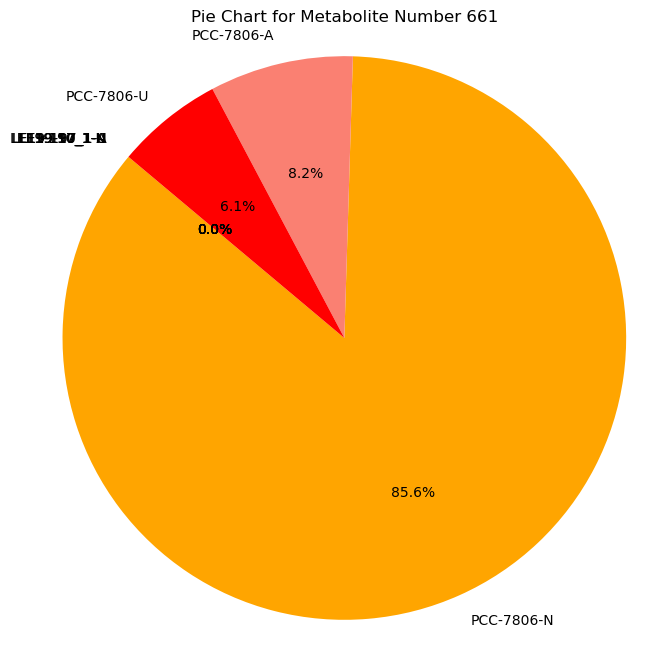

In [32]:
# Step 4: Create labeled pie chart of the relative contribution of each treatment to the total normalized peak area of a metabolite
df = pd.DataFrame(result)
df.set_index('Metabolite', inplace=True)  # Set metabolite column as index


# Define groups manually
group_mapping = {
    'PCC-7806-N': ['PCC-7806-N1', 'PCC7806-N2', 'PCC7806-N3'],
    'PCC-7806-A': ['PCC-7806-A1', 'PCC7806-A2', 'PCC7806-A3'],
    'PCC-7806-U': ['PCC-7806-U1', 'PCC7806-U2', 'PCC7806-U3'],
    'LE19-197_1-N': ['LE19-197_1-N1', 'LE19-197_1-N2', 'LE19-197_1-N3'],
    'LE19-197_1-A': ['LE19-197_1-A1', 'LE19-197_1-A2', 'LE19-197_1-A3'],
    'LE19-197_1-U': ['LE19-197_1-U1', 'LE-197_1-U2', 'LE19-197_1-U3'],
    'LE19-10_1-N': ['LE19-10_1-N1', 'LE19-10_1-N2', 'LE19-10_1-N3'],
    'LE19-10_1-A': ['LE19-10_1-A1', 'LE19-10_1-A2', 'LE19-10_1-A3'],
    'LE19-10_1-U': ['LE19-10_1-U1', 'LE19-10_1-U2', 'LE19-10_1-U3'],
}

# Group columns and sum their values
grouped_df = pd.DataFrame()
for group, columns in group_mapping.items():
    grouped_df[group] = df[columns].sum(axis=1)

# Function to create pie chart for a selected metabolite number
def create_pie_chartlabeled(metabolite_number):
    if metabolite_number in df.index:  # Check if metabolite number exists in index
        row = grouped_df.loc[metabolite_number]
        labels = row.index
        values = row.values

        # Define colors for each slice
        colors = ['orange', 'salmon', 'red', 'turquoise', 'limegreen', 'green', 'blueviolet', 'cornflowerblue', 'blue']
        
        plt.figure(figsize=(8, 8))
        plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
        plt.title(f'Pie Chart for Metabolite Number {metabolite_number}')
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        plt.show()
    else:
        print(f"Metabolite number {metabolite_number} not found in the DataFrame.")

# Create pie chart for metabolite number 661
create_pie_chartlabeled(661)#microcystin

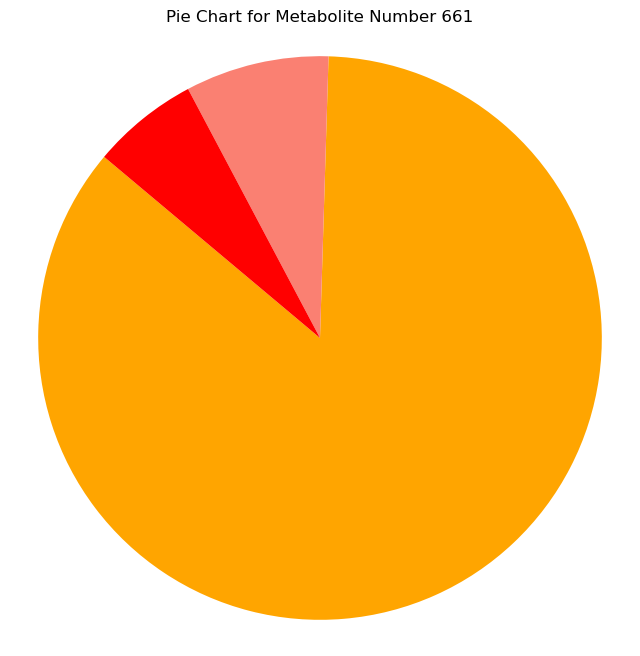

In [35]:
# Step 4.5: Create unlabeled pie chart of the relative contribution of each treatment to the total normalized peak area of a metabolite
df = pd.DataFrame(result)
df.set_index('Metabolite', inplace=True)  # Set metabolite column as index


# Define groups manually
group_mapping = {
    'PCC-7806-N': ['PCC-7806-N1', 'PCC7806-N2', 'PCC7806-N3'],
    'PCC-7806-A': ['PCC-7806-A1', 'PCC7806-A2', 'PCC7806-A3'],
    'PCC-7806-U': ['PCC-7806-U1', 'PCC7806-U2', 'PCC7806-U3'],
    'LE19-197_1-N': ['LE19-197_1-N1', 'LE19-197_1-N2', 'LE19-197_1-N3'],
    'LE19-197_1-A': ['LE19-197_1-A1', 'LE19-197_1-A2', 'LE19-197_1-A3'],
    'LE19-197_1-U': ['LE19-197_1-U1', 'LE-197_1-U2', 'LE19-197_1-U3'],
    'LE19-10_1-N': ['LE19-10_1-N1', 'LE19-10_1-N2', 'LE19-10_1-N3'],
    'LE19-10_1-A': ['LE19-10_1-A1', 'LE19-10_1-A2', 'LE19-10_1-A3'],
    'LE19-10_1-U': ['LE19-10_1-U1', 'LE19-10_1-U2', 'LE19-10_1-U3'],
}

# Group columns and sum their values
grouped_df = pd.DataFrame()
for group, columns in group_mapping.items():
    grouped_df[group] = df[columns].sum(axis=1)

# Function to create pie chart for a selected metabolite number
def create_pie_chart(metabolite_number):
    if metabolite_number in df.index:  # Check if metabolite number exists in index
        row = grouped_df.loc[metabolite_number]
        labels = row.index
        values = row.values

        # Define colors for each slice
        colors = ['orange', 'salmon', 'red', 'turquoise', 'limegreen', 'green', 'darkorchid', 'cornflowerblue', 'blue']
        
        plt.figure(figsize=(8, 8))
        plt.pie(values, autopct='', startangle=140, colors=colors)
        plt.title(f'Pie Chart for Metabolite Number {metabolite_number}')
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        plt.show()
    else:
        print(f"Metabolite number {metabolite_number} not found in the DataFrame.")

# Create pie chart for metabolite number 661
create_pie_chart(661)#microcystin

In [43]:
# Step 5: Perform center scaling on the DataFrame

from sklearn.preprocessing import StandardScaler

# Move 'Metabolite' column to the first position
cols = ['Metabolite'] + [col for col in result.columns if col != 'Metabolite']
result = result[cols]

# Transpose the DataFrame with 'Metabolite' as column names
ft_t = result.set_index('Metabolite').transpose()

# Apply StandardScaler
scaler = StandardScaler()
ft_t_scaled = pd.DataFrame(scaler.fit_transform(ft_t),
                           index=ft_t.index,   
                           columns=ft_t.columns)  

# Re-transpose to original structure
result_scaled = ft_t_scaled.transpose().reset_index()

# Rename 'index' back to 'Metabolite'
result_scaled = result_scaled.rename(columns={'index': 'Metabolite'})

# Display the first 3 rows
result_scaled.head(n=3)


,Metabolite,LE-197_1-U2,LE19-10_1-A1,LE19-10_1-A2,LE19-10_1-A3,LE19-10_1-N1,LE19-10_1-N2,LE19-10_1-N3,LE19-10_1-U1,LE19-10_1-U2,...,LE19-197_1-U3,PCC-7806-A1,PCC-7806-N1,PCC-7806-U1,PCC7806-A2,PCC7806-A3,PCC7806-N2,PCC7806-N3,PCC7806-U2,PCC7806-U3
0,640,-0.696340,-0.303169,-0.050952,-0.003241,1.258155,-0.395337,1.765017,-0.593704,0.768347,...,-0.543853,-0.632992,3.076972,-0.686905,-0.617018,-0.539866,1.488844,0.999755,-0.674536,-0.510963
1,171,-0.744166,0.069161,-0.054133,-0.139252,3.204415,0.778550,1.868229,-0.445498,-0.216416,...,-0.748076,-0.716641,0.493222,-0.807299,-0.682059,-0.805012,1.590265,1.458835,-0.744344,-0.800729
2,786,-0.343780,-0.343780,-0.343780,-0.343780,-0.343780,-0.343780,-0.343780,-0.343780,-0.343780,...,-0.343780,-0.343780,2.192121,-0.343780,-0.343780,-0.343780,2.320502,3.738106,-0.343780,-0.343780


In [44]:
# Step 6: Save as csv
result_scaled.to_csv("poc_normalized_ft.csv", index=False)
print("DataFrame saved as 'poc_normalized_ft.csv'")

DataFrame saved as 'poc_normalized_ft.csv'


In [49]:
#Part 2

# Step 1: Load normalized peak area file integrated with SIRIUS annotations from Cytoscape
ftmerge = pd.read_csv("afterPOCcytoscapeforheatmapedited.csv")
print(ftmerge)

             Adduct  AllGroups Analog:Adduct Analog:Compound_Name   
0          [M + H]+        NaN           NaN                  NaN  \
1    [M + H3N + H]+        NaN           NaN                  NaN   
2    [M + H3N + H]+        NaN           NaN                  NaN   
3          [M + H]+        NaN           NaN                  NaN   
4    [M - H2O + H]+        NaN           NaN                  NaN   
..              ...        ...           ...                  ...   
269  [M - H2O + H]+        NaN           NaN                  NaN   
270        [M + H]+        NaN           NaN                  NaN   
271        [M + H]+        NaN           NaN                  NaN   
272             NaN        NaN           NaN                  NaN   
273  [M - H2O + H]+        NaN           NaN                  NaN   

    Analog:Compound_Source Analog:Data_Collector Analog:GNPSLibraryURL   
0                      NaN                   NaN                   NaN  \
1                      

In [50]:
# Step 2: Remove any superclass/class/subclass assigned with less than 80% probability

# Initial count of NaN values
initial_nan_superclass = ftmerge['ClassyFire#superclass'].isna().sum()
initial_nan_class = ftmerge['ClassyFire#class'].isna().sum()
initial_nan_subclass = ftmerge['ClassyFire#subclass'].isna().sum()

# Apply the conditions
ftmerge.loc[ftmerge['ClassyFire#superclass probability'] < 0.80, 'ClassyFire#superclass'] = np.nan
ftmerge.loc[ftmerge['ClassyFire#class Probability'] < 0.80, 'ClassyFire#class'] = np.nan
ftmerge.loc[ftmerge['ClassyFire#subclass Probability'] < 0.80, 'ClassyFire#subclass'] = np.nan

# Recalculate NaN values after applying conditions
final_nan_superclass = ftmerge['ClassyFire#superclass'].isna().sum()
final_nan_class = ftmerge['ClassyFire#class'].isna().sum()
final_nan_subclass = ftmerge['ClassyFire#subclass'].isna().sum()

# Calculate how many values were converted to NaN
converted_to_nan_superclass = final_nan_superclass - initial_nan_superclass
converted_to_nan_class = final_nan_class - initial_nan_class
converted_to_nan_subclass = final_nan_subclass - initial_nan_subclass

# Print results
print(f"Initial NaN count in 'ClassyFire#superclass': {initial_nan_superclass}")
print(f"Initial NaN count in 'ClassyFire#class': {initial_nan_class}")
print(f"Initial NaN count in 'ClassyFire#subclass': {initial_nan_subclass}")

print(f"Final NaN count in 'ClassyFire#superclass': {final_nan_superclass}")
print(f"Final NaN count in 'ClassyFire#class': {final_nan_class}")
print(f"Final NaN count in 'ClassyFire#subclass': {final_nan_subclass}")

Initial NaN count in 'ClassyFire#superclass': 15
Initial NaN count in 'ClassyFire#class': 17
Initial NaN count in 'ClassyFire#subclass': 49
Final NaN count in 'ClassyFire#superclass': 28
Final NaN count in 'ClassyFire#class': 62
Final NaN count in 'ClassyFire#subclass': 110


In [60]:
# Step 3: Select the columns that contain center-scaled peak area data

# List of specific numerical columns
numerical_columns = pd.concat([ftmerge[ftmerge.columns[pd.Series(ftmerge.columns).str.startswith('PCC')]],  ftmerge[ftmerge.columns[pd.Series(ftmerge.columns).str.startswith('LE')]]], axis=1)
numerical_columns = numerical_columns.columns[:]

# Ensure numerical columns are correctly identified
numerical_columns = [col for col in numerical_columns if col in ftmerge.columns]

# Convert numerical columns from strings to numeric data types, forcing errors to NaN
for col in numerical_columns:
    ftmerge[col] = pd.to_numeric(ftmerge[col], errors='coerce')

# Verify if the conversion was successful
print(ftmerge[numerical_columns].dtypes)

PCC-7806-A1      float64
PCC-7806-N1      float64
PCC-7806-U1      float64
PCC7806-A2       float64
PCC7806-A3       float64
PCC7806-N2       float64
PCC7806-N3       float64
PCC7806-U2       float64
PCC7806-U3       float64
LE-197_1-U2      float64
LE19-10_1-A1     float64
LE19-10_1-A2     float64
LE19-10_1-A3     float64
LE19-10_1-N1     float64
LE19-10_1-N2     float64
LE19-10_1-N3     float64
LE19-10_1-U1     float64
LE19-10_1-U2     float64
LE19-10_1-U3     float64
LE19-197_1-A1    float64
LE19-197_1-A2    float64
LE19-197_1-A3    float64
LE19-197_1-N1    float64
LE19-197_1-N2    float64
LE19-197_1-N3    float64
LE19-197_1-U1    float64
LE19-197_1-U3    float64
dtype: object


In [62]:
# Step 4: Group features (rows) by superclass, then by class, then arrange rows according to euclidean distance of center scaled peak area data
#This means every metabolite belonging to a given superclass will be grouped together vertically on the heatmap, and then within the superclass, features belonging to the same class will be grouped together vertically as well

# Function to sort rows by Euclidean distance of peak area data
def sort(df):
    # Extract the numerical values
    numerical_values = df[numerical_columns].values
    if len(numerical_values) > 1:
        # Compute pairwise Euclidean distances
        distances = pdist(numerical_values, metric='euclidean')
        # Convert to a squareform distance matrix
        distance_matrix = squareform(distances)
        # Get the order of indices that would sort the matrix by Euclidean distance
        sorted_indices = np.argsort(distance_matrix.sum(axis=1))
        # Reorder the DataFrame according to these indices
        sorted_df = df.iloc[sorted_indices]
    else:
        sorted_df = df
    return sorted_df

# Replace NaNs with a placeholder value
ftmerge['ClassyFire#superclass'].fillna('NaN_group', inplace=True)
ftmerge['ClassyFire#class'].fillna('NaN_group', inplace=True)

# Apply the grouping and sorting function
newftmerge = ftmerge.groupby(['ClassyFire#superclass', 'ClassyFire#class']).apply(sort)

# Revert placeholder back to NaN
newftmerge['ClassyFire#superclass'].replace('NaN_group', np.nan, inplace=True)
newftmerge['ClassyFire#class'].replace('NaN_group', np.nan, inplace=True)

# Drop the group keys added by groupby
newftmerge = newftmerge.reset_index(drop=True)

# Print the first 10 rows of the sorted DataFrame
print(newftmerge[["name", "ClassyFire#subclass", "ClassyFire#class", "ClassyFire#superclass"]].head(10))
print(f"Number of rows in DataFrame: {len(newftmerge)}")

   name        ClassyFire#subclass                     ClassyFire#class   
0   110  Benzenesulfonyl compounds  Benzene and substituted derivatives  \
1   101  Benzenesulfonyl compounds  Benzene and substituted derivatives   
2   507                        NaN  Benzene and substituted derivatives   
3   304                   Anilides  Benzene and substituted derivatives   
4   238                        NaN  Benzene and substituted derivatives   
5   406        Benzenesulfonamides  Benzene and substituted derivatives   
6   576                        NaN                                  NaN   
7   575                        NaN                                  NaN   
8   191                        NaN                                  NaN   
9   294                        NaN                                  NaN   

  ClassyFire#superclass  
0            Benzenoids  
1            Benzenoids  
2            Benzenoids  
3            Benzenoids  
4            Benzenoids  
5            Benze

In [68]:
# Step 5: Group the columns of the heatmap/leaves of the dendrogram according to treatment
# This ensures columns of the same treatment will not cluster separately

# Define manual groupings
PCC7806A = ['PCC-7806-A1', 'PCC7806-A2', 'PCC7806-A3']
PCC7806U = ['PCC-7806-U1', 'PCC7806-U2', 'PCC7806-U3']
PCC7806N = ['PCC-7806-N1', 'PCC7806-N2', 'PCC7806-N3']
LE19101A = ['LE19-10_1-A1', 'LE19-10_1-A2', 'LE19-10_1-A3']
LE19101U = ['LE19-10_1-U1', 'LE19-10_1-U2', 'LE19-10_1-U3']
LE19101N = ['LE19-10_1-N1', 'LE19-10_1-N2', 'LE19-10_1-N3']
LE191971A = ['LE19-197_1-A1', 'LE19-197_1-A2', 'LE19-197_1-A3']
LE191971U = ['LE19-197_1-U1', 'LE-197_1-U2', 'LE19-197_1-U3']
LE191971N = ['LE19-197_1-N1', 'LE19-197_1-N2', 'LE19-197_1-N3']

# Combine the groups into a list
manual_groups = [PCC7806A, PCC7806U, PCC7806N, LE19101A, LE19101U, LE19101N, LE191971A, LE191971U, LE191971N]

In [69]:
# Step 6: Perform heirarchical clustering on treatment groups

# Dictionary to store linkage matrices for each group
group_linkages = {}

for i, group in enumerate(manual_groups):
    # Extract the subset of peak areas for the group
    group_data = ftmerge[group].T  # Transpose to cluster columns
    # Compute linkage matrix for the group
    group_linkages[f"group_{i+1}"] = linkage(pdist(group_data, metric='euclidean'), method='complete')
    
# Calculate distances between groups (group centroids)
group_centroids = []
for group in manual_groups:
    group_data = ftmerge[group].T
    centroid = group_data.mean(axis=0)
    group_centroids.append(centroid)

# Combine group centroids into a matrix
group_centroids_matrix = np.vstack(group_centroids)

# Perform hierarchical clustering on group centroids
group_linkage = linkage(pdist(group_centroids_matrix, metric='euclidean'), method='complete')


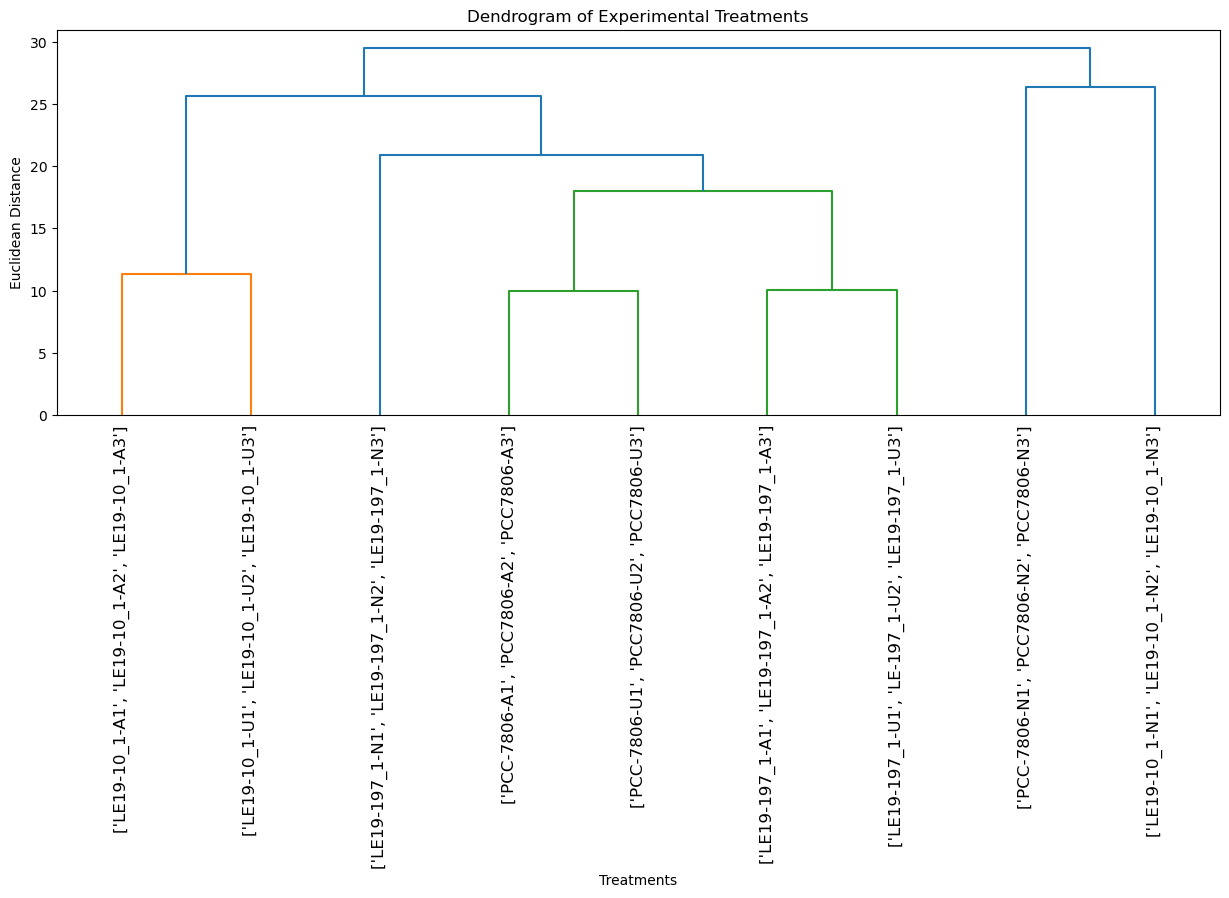

In [109]:
# Step 7: Plot the higher-level group dendrogram
plt.figure(figsize=(15, 5))
dendrogram(
    group_linkage,
    labels=manual_groups, 
    orientation='top',
    leaf_rotation=90
)
plt.title("Dendrogram of Experimental Treatments")
plt.xlabel("Treatments")
plt.ylabel("Euclidean Distance")
plt.show()

In [81]:
# Step 8: Get unique superclasses and classes with counts for creation of vertical color bars
superclass_counts = newftmerge['ClassyFire#superclass'].value_counts()
class_counts = newftmerge['ClassyFire#class'].value_counts()

# Convert to lists for alignment
superclass_list = list(superclass_counts.items())
class_list = list(class_counts.items())

# Determine max length to iterate safely
max_length = max(len(superclass_list), len(class_list))

# Print the header
print(f"{'Superclass':<40}{'Count':<10} | {'Class':<40}{'Count'}")
print("="*95)

# Iterate and print both lists side by side
for i in range(max_length):
    superclass_entry = superclass_list[i] if i < len(superclass_list) else ("", "")
    class_entry = class_list[i] if i < len(class_list) else ("", "")
    
    print(f"{superclass_entry[0]:<40}{superclass_entry[1]:<10} | {class_entry[0]:<40}{class_entry[1]}")


Superclass                              Count      | Class                                   Count
Organic acids and derivatives           114        | Carboxylic acids and derivatives        96
Organoheterocyclic compounds            57         | Imidazopyrimidines                      16
Lipids and lipid-like molecules         20         | Organooxygen compounds                  14
Organic oxygen compounds                15         | Fatty Acyls                             13
Benzenoids                              14         | Organonitrogen compounds                10
Nucleosides, nucleotides, and analogues 14         | Diazines                                8
Organic nitrogen compounds              10         | Pyridines and derivatives               7
Hydrocarbons                            1          | Benzene and substituted derivatives     6
Organosulfur compounds                  1          | Purine nucleosides                      6
                                         

In [93]:
# Step 9: Extract center-scaled peak area columns for heatmap
peak_areas = newftmerge[numerical_columns]

# Rename the rows using the values from the "name" column
peak_areas.index = newftmerge['name']

In [94]:
# Step 10: Extract the order of columns based on heirarchical clustering of treatments
group_order_indices = hierarchy.leaves_list(group_linkage)
ordered_groups = [manual_groups[i] for i in group_order_indices]

# Flatten the ordered group list to get the final column order
ordered_columns = [col for group in ordered_groups for col in group]

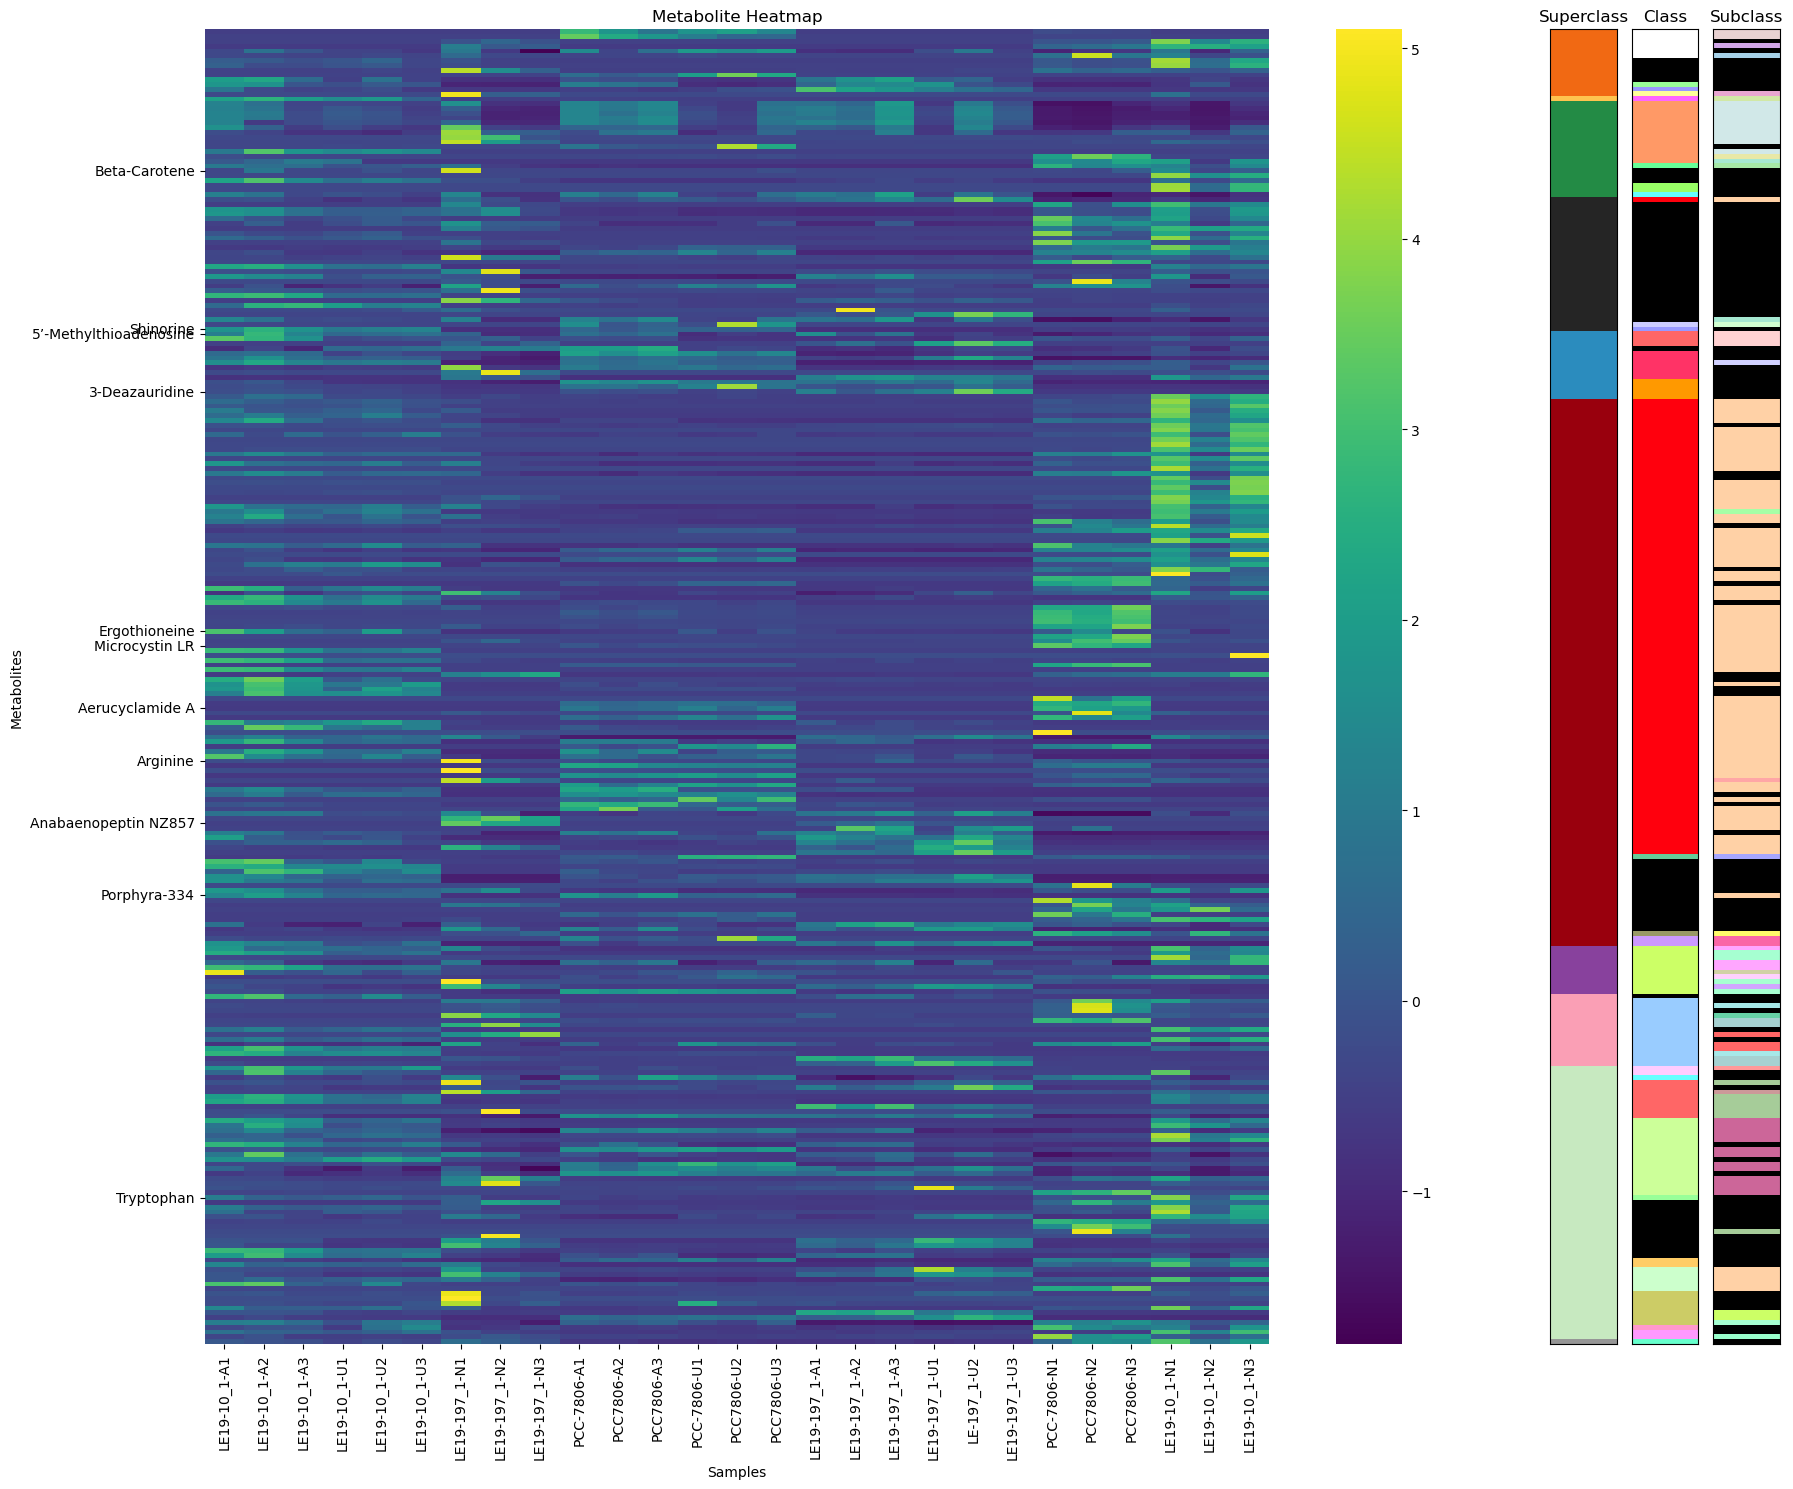

In [97]:
# Step 11: Create heatmap with features as rows and treatments as columns

# Existing superclass color map
superclass_color_map = {
    'Alkaloids and derivatives': '#9ECAE1',
    'Benzenoids': '#F16913',
    'Hydrocarbons': '#FEC44F',
    'Lipids and lipid-like molecules': '#238B45',
    'Nucleosides, nucleotides, and analogues': '#2B8CBE',
    'Organic acids and derivatives': '#99000D',
    'Organic nitrogen compounds': '#88419D',
    'Organic oxygen compounds': '#FA9FB5',
    'Organoheterocyclic compounds': '#C7E9C0',
    'Organophosphorus compounds': '#FFF7BC',
    'Organosulfur compounds': '#969696',
    'Phenylpropanoids and polyketides': '#E7298A',
    'NaN': '#252525'
}

# Create a color palette from the color map
superclass_palette = list(superclass_color_map.values())

# Assuming 'newftmerge' is your DataFrame and 'ClassyFire#superclass' is the column for superclasses
color_bar = newftmerge.set_index('name')['ClassyFire#superclass'].map(superclass_color_map)

# Check if all values are correctly mapped
if color_bar.isnull().any():
    # Set unmapped values to 'NaN' for the palette
    color_bar = color_bar.fillna(superclass_color_map['NaN'])

# Convert colors to indices for colormap
color_indices = np.array([superclass_palette.index(color) for color in color_bar])

# Create a colormap and norm for the color bar
cmap = mcolors.ListedColormap(superclass_palette)
bounds = np.arange(len(superclass_palette) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)


# Class color map filled with provided classes
class_color_map = {
    'Benzene and substituted derivatives': '#FFFFFF',
    'Naphthalenes': '#99FF99',
    'Phenol ethers': '#9999FF',
    'Phenols': '#FFFF99',
    'Unsaturated hydrocarbons': '#FF66FF',
    'Fatty Acyls': '#FF9966',
    'Glycerophospholipids': '#66FF99',
    'Prenol lipids': '#99FF66',
    'Steroids and steroid derivatives': '#66FFFF',
    'Carboxylic acids and derivatives': '#FF000D',
    'Oxathianes': '#CCCCFF',
    "5'-deoxyribonucleosides": '#FF6666',
    'Purine nucleosides': '#FF3366',
    'Pyrimidine nucleosides': '#FF9900',
    'Hydroxy acids and derivatives': '#66CC99',
    'Organic phosphoric acids and derivatives': '#999966',
    'Organic sulfonic acids and derivatives': '#CC99FF',
    'Organonitrogen compounds': '#CCFF66',
    'Organooxygen compounds': '#99CCFF',
    'Azoles': '#FFCCFF',
    'Benzimidazoles': '#66FFFF',
    'Diazines': '#FF6666',
    'Imidazopyrimidines': '#CCFF99',
    'Indoles and derivatives': '#99FF99',
    'Piperidines': '#FFCC66',
    'Pteridines and derivatives': '#CCFFCC',
    'Pyridines and derivatives': '#CCCC66',
    'Pyrrolidines': '#FF99CC',
    'Quinolines and derivatives': '#FF99FF',
    'Sulfoxides': '#66FFCC',
    'Cinnamic acids and derivatives': '#FF9933',
    'NaN': '#000000'
}

# Create a color palette for classes
class_palette = list(class_color_map.values())

# Extract unique classes from the DataFrame
unique_classes = newftmerge['ClassyFire#class'].unique()
#print("Unique classes in the DataFrame:", unique_classes)

# Map the classes to the colors
color_bar_classes = newftmerge.set_index('name')['ClassyFire#class'].map(class_color_map)

# Check if all values are correctly mapped
if color_bar_classes.isnull().any():
    # Set unmapped values to 'NaN' for the palette
    color_bar_classes = color_bar_classes.fillna(class_color_map['NaN'])

class_color_indices = np.array([class_palette.index(color) for color in color_bar_classes])

# Create a colormap and norm for the class color bar
cmap_classes = mcolors.ListedColormap(class_palette)
bounds_classes = np.arange(len(class_palette) + 1) - 0.5
norm_classes = mcolors.BoundaryNorm(bounds_classes, cmap_classes.N)

# Subclass color map filled with provided subclasses
subclass_color_map = {
    'Anilides': '#D1A6E8',
    'Benzenesulfonamides': '#A6D1E8',
    'Benzenesulfonyl compounds': '#E8D1D1',
    'Benzenetriols and derivatives': '#E8A6D1',
    'Olefins': '#D1E8A6',
    'Fatty acid esters': '#E8E8A6',
    'Fatty acids and conjugates': '#D1E8E8',
    'Fatty amides': '#A6E8D1',
    'Glycerophosphates': '#A6E8A6',
    'Amino acids, peptides, and analogues': '#FFD1A6',
    'Delta sultones': '#D1FFD1',
    "5'-deoxy-5'-thionucleosides": '#FFD1D1',
    "Purine 2'-deoxyribonucleosides": '#D1D1FF',
    'Carboxylic acid derivatives': '#FFA6A6',
    'Dicarboxylic acids and derivatives': '#A6FFA6',
    'Beta hydroxy acids and derivatives': '#A6A6FF',
    'Phosphate esters': '#FFFA6A',
    'Organosulfonic acids and derivatives': '#FA66A6',
    'Amines': '#FFA6FF',
    'Cyclohexylamines': '#D1D1A6',
    'Guanidines': '#A6FFD1',
    'N-arylamides': '#D1A6FF',
    'Quaternary ammonium salts': '#FFD1FF',
    'Alcohols and polyols': '#66D1A6',
    'Carbohydrates and carbohydrate conjugates': '#A6D1D1',
    'Carbonyl compounds': '#FF6666',
    'Ethers': '#A6E8E8',
    'Imidazoles': '#FF9999',
    'Pyrazines': '#CC9999',
    'Pyrimidines and pyrimidine derivatives': '#A6CC99',
    'Purines and purine derivatives': '#CC6699',
    'Pterins and derivatives': '#FFD1A6',
    'Pyridinecarboxylic acids and derivatives': '#A6FFD1',
    'Pyridoxines': '#CCFF66',
    'Quinolones and derivatives': '#99FFCC',
    'Hydroxycinnamic acids and derivatives': '#FFA6CC',
    'NaN': '#000000'  # Color for NaN values
}

# Create a color palette for subclasses
subclass_palette = list(subclass_color_map.values())

# Extract unique subclasses from the DataFrame
unique_subclasses = newftmerge['ClassyFire#subclass'].unique()
#print("Unique subclasses in the DataFrame:", unique_subclasses)

# Map the subclasses to the colors
color_bar_subclasses = newftmerge.set_index('name')['ClassyFire#subclass'].map(subclass_color_map)

# Check if all values are correctly mapped
if color_bar_subclasses.isnull().any():
    color_bar_subclasses = color_bar_subclasses.fillna(subclass_color_map['NaN'])

subclass_color_indices = np.array([subclass_palette.index(color) for color in color_bar_subclasses])

# Create a colormap and norm for the subclass color bar
cmap_subclasses = mcolors.ListedColormap(subclass_palette)
bounds_subclasses = np.arange(len(subclass_palette) + 1) - 0.5
norm_subclasses = mcolors.BoundaryNorm(bounds_subclasses, cmap_subclasses.N)

# Create a gridspec layout with four columns for the heatmap and color bars
fig = plt.figure(figsize=(18, 15))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 0.05, 0.05, 0.05])

# Prepare y-axis labels and ticks
labels = newftmerge.set_index('name').apply(
    lambda x: x['Analog:Compound_Name'] if pd.notnull(x['Analog:Compound_Name']) else '', axis=1
).tolist()

# Determine which rows have labels
yticks = [i + 0.5 for i, label in enumerate(labels) if label]
yticklabels = [label for label in labels if label]

# Add the superclass color bar
ax1 = fig.add_subplot(gs[1])
ax1.imshow(color_indices.reshape(-1, 1), cmap=cmap, norm=norm, aspect='auto')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_title('Superclass')

# Add the class color bar
ax2 = fig.add_subplot(gs[2])
ax2.imshow(class_color_indices.reshape(-1, 1), cmap=cmap_classes, norm=norm_classes, aspect='auto')
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_title('Class')

# Add the subclass color bar
ax3 = fig.add_subplot(gs[3])
ax3.imshow(subclass_color_indices.reshape(-1, 1), cmap=cmap_subclasses, norm=norm_subclasses, aspect='auto')
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_title('Subclass')

# Add the heatmap
ax4 = fig.add_subplot(gs[0])
heatmap = sns.heatmap(peak_areas[ordered_columns], cmap='viridis', ax=ax4, yticklabels=labels)
ax4.set_xlabel('Samples')
ax4.set_ylabel('Metabolites')
ax4.set_title('Metabolite Heatmap')

# Update y-ticks to only show where labels exist and ensure they are centered
heatmap.set_yticks(yticks)
heatmap.set_yticklabels(yticklabels, rotation=0)

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()


In [98]:
# Step 12: Group data by superclass, class, and subclass
grouped = newftmerge.groupby(['ClassyFire#superclass', 'ClassyFire#class', 'ClassyFire#subclass']).size()

# Print a list showing each superclass with its classes and subclasses
for superclass, class_group in grouped.groupby(level=0):
    print(f"\nSuperclass: {superclass}")
    for cls, subclass_group in class_group.groupby(level=1):
        print(f"  Class: {cls}")
        subclasses = subclass_group.index.get_level_values(2).unique()
        for subclass in subclasses:
            print(f"    Subclass: {subclass}")


Superclass: Benzenoids
  Class: Benzene and substituted derivatives
    Subclass: Anilides
    Subclass: Benzenesulfonamides
    Subclass: Benzenesulfonyl compounds
  Class: Phenols
    Subclass: Benzenetriols and derivatives

Superclass: Hydrocarbons
  Class: Unsaturated hydrocarbons
    Subclass: Olefins

Superclass: Lipids and lipid-like molecules
  Class: Fatty Acyls
    Subclass: Fatty acid esters
    Subclass: Fatty acids and conjugates
    Subclass: Fatty amides
  Class: Glycerophospholipids
    Subclass: Glycerophosphates

Superclass: Nucleosides, nucleotides, and analogues
  Class: 5'-deoxyribonucleosides
    Subclass: 5'-deoxy-5'-thionucleosides
  Class: Purine nucleosides
    Subclass: Purine 2'-deoxyribonucleosides

Superclass: Organic acids and derivatives
  Class: Carboxylic acids and derivatives
    Subclass: Amino acids, peptides, and analogues
    Subclass: Carboxylic acid derivatives
    Subclass: Dicarboxylic acids and derivatives
  Class: Hydroxy acids and derivati

In [99]:
# Step 13: Select a treatment group to examine the molecular network composition of
# Select rows where values in columns 'PCC7806-A1', 'PCC7806-A2', or 'PCC7806-A3' are greater than 1
# This means that, if the center-scaled average peak area of all treatments is 0, then any feature with a peak area above 0 was detected in above-average levels
PCC7806A_positive = newftmerge[(newftmerge['PCC-7806-A1'] > 1) | 
                               (newftmerge['PCC7806-A2'] > 1) | 
                               (newftmerge['PCC7806-A3'] > 1)]

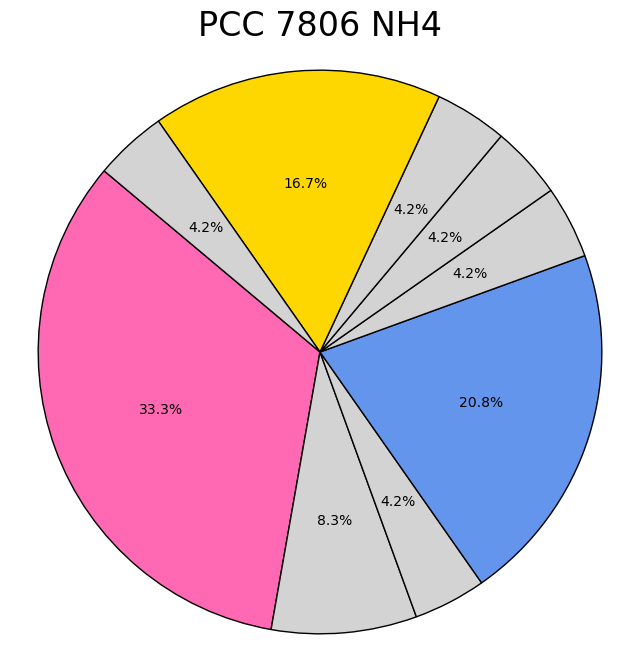

Amino acids, peptides, and analogues: 33.3%
Benzenesulfonyl compounds: 8.3%
Delta sultones: 4.2%
Fatty acids and conjugates: 20.8%
Fatty amides: 4.2%
Guanidines: 4.2%
Organosulfonic acids and derivatives: 4.2%
Purines and purine derivatives: 16.7%
Pyrimidines and pyrimidine derivatives: 4.2%
     shared name                     ClassyFire#subclass   
0            110               Benzenesulfonyl compounds  \
1            101               Benzenesulfonyl compounds   
15            98              Fatty acids and conjugates   
16            74              Fatty acids and conjugates   
17            82              Fatty acids and conjugates   
18            83              Fatty acids and conjugates   
19           104              Fatty acids and conjugates   
60            92                            Fatty amides   
61           411                          Delta sultones   
148          204    Amino acids, peptides, and analogues   
150          223    Amino acids, peptides, and 

In [100]:
# Step 14: Create a pie chart showing the subclass composition of features detected at above-average levels within a certain treatment group, with three largest subclasses colored

PCC7806A_positive = PCC7806A_positive[PCC7806A_positive['ClassyFire#subclass Probability'] >= 0.80]

# Manually assign colors to specific subclasses
subclass_colors = {
    'Amino acids, peptides, and analogues': 'hotpink',
    'Fatty acids and conjugates': 'cornflowerblue',
    'Purines and purine derivatives': 'gold',
    # Add more subclasses and colors as needed
}

grouped_posPCC7806Adf = PCC7806A_positive.groupby('ClassyFire#subclass').size().reset_index(name='subclasscount')

# Extract the labels (class names) and sizes (counts) from the grouped DataFrame
labels = grouped_posPCC7806Adf['ClassyFire#subclass'].tolist()
sizes = grouped_posPCC7806Adf['subclasscount'].tolist()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, autopct='%1.1f%%', startangle=140, colors=[subclass_colors.get(subclass, 'lightgray') for subclass in labels], wedgeprops={'linewidth': 1, 'edgecolor': 'black'})

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Add a title
plt.title('PCC 7806 NH4', fontsize=24)

# Show the plot
plt.show()

# Initialize an empty list to store slice information
slice_info = []

# Calculate the total sum of sizes
total_size = sum(sizes)

# Iterate over each label and size
for label, size in zip(labels, sizes):
    # Format the percentage
    percentage = '{:.1f}%'.format(100 * size / total_size)
    # Create a string containing the label and percentage
    info = f'{label}: {percentage}'
    # Append the string to the slice_info list
    slice_info.append(info)

# Print the list of slice titles and percentages
for info in slice_info:
    print(info)
    
print(PCC7806A_positive.loc[:, ['shared name', 'ClassyFire#subclass', 'ClassyFire#subclass Probability']])
num_rows = PCC7806A_positive.shape[0]
print("Number of rows:", num_rows)

In [101]:
# Step 15: Select for features found only in N treatment
Nonly_spentmedia_df = newftmerge[(newftmerge["ATTRIBUTE_media"] == 'N') & (newftmerge["ATTRIBUTE_control"] == 'spentmedia') & ~(newftmerge["ATTRIBUTE_media"] == 'blank')]

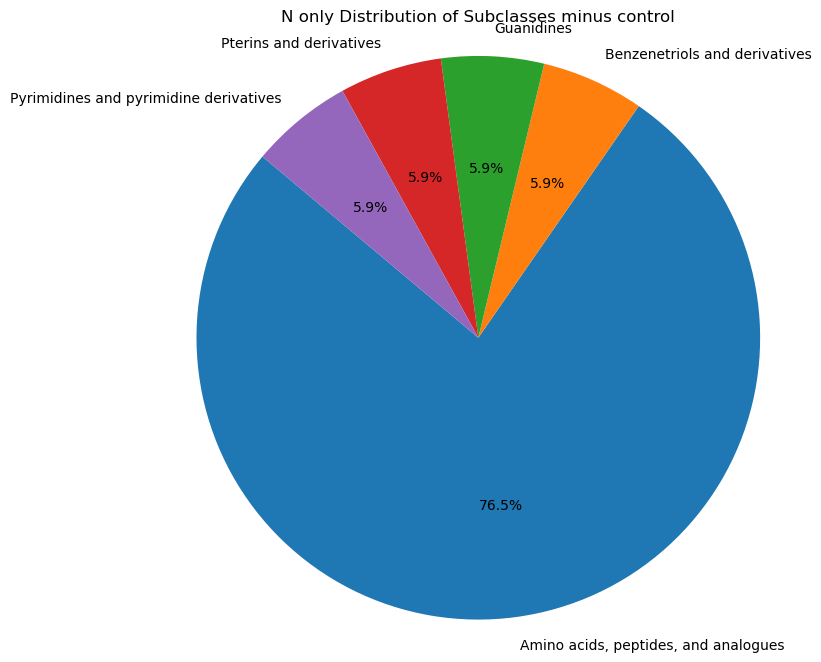

Number of rows: 24


In [104]:
# Step 16: Create pie chart of subclasses of features found only in N treatment
grouped_smNonlydf = Nonly_spentmedia_df.groupby('ClassyFire#subclass').size().reset_index(name='subclasscount')

# Extract the labels (class names) and sizes (counts) from the grouped DataFrame
labels = grouped_smNonlydf['ClassyFire#subclass'].tolist()
sizes = grouped_smNonlydf['subclasscount'].tolist()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Add a title
plt.title('N only Distribution of Subclasses minus control')

# Show the plot
plt.show()

#print(Nonly_spentmedia_df.loc[:, ['shared name', 'ClassyFire#subclass', 'ClassyFire#subclass Probability', 'ClassyFire#superclass']])

num_rows = Nonly_spentmedia_df.shape[0]
print("Number of rows:", num_rows)

In [105]:
# Step 17: Select for features found only in A and U treatments
AUonly_spentmedia_df = newftmerge[~(newftmerge["ATTRIBUTE_media"].str.contains('N')) & (newftmerge["ATTRIBUTE_control"] == 'spentmedia') & ~(newftmerge["ATTRIBUTE_media"] == 'blank')]

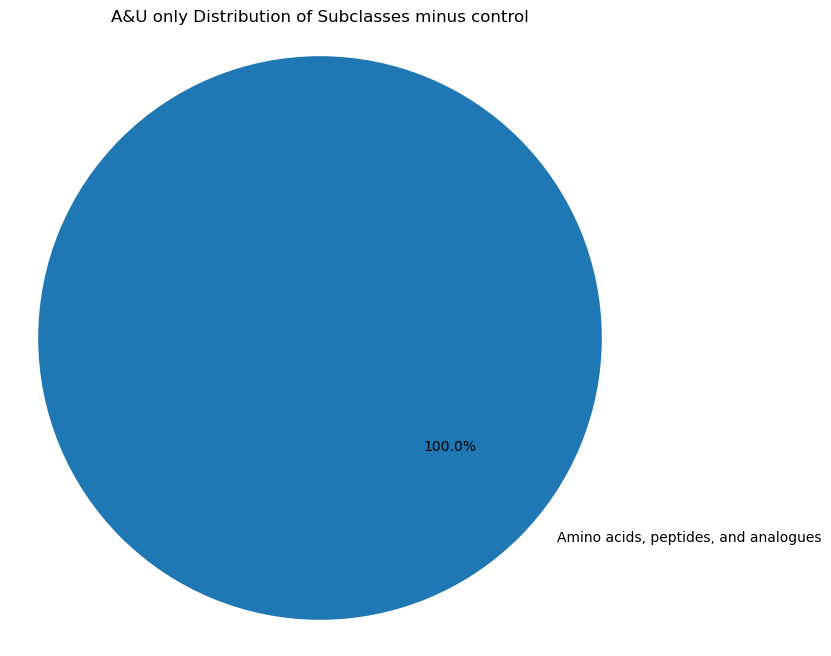

Number of rows: 11


In [107]:
# Step 18: Create pie chart of subclasses of features found only in A and U treatments
grouped_smAUonlydf = AUonly_spentmedia_df.groupby('ClassyFire#subclass').size().reset_index(name='subclasscount')

# Extract the labels (class names) and sizes (counts) from the grouped DataFrame
labels = grouped_smAUonlydf['ClassyFire#subclass'].tolist()
sizes = grouped_smAUonlydf['subclasscount'].tolist()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Add a title
plt.title('A&U only Distribution of Subclasses minus control')

# Show the plot
plt.show()

num_rows = AUonly_spentmedia_df.shape[0]
print("Number of rows:", num_rows)